In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
# import libraries
import open3d as o3d
import numpy as np
import glob
import os
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow.keras.backend as K

In [ ]:
#Point cloud visualization
def visualize_sample(sample, title=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    xyz = sample[:, :3]

    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='blue', s=1)  # single color
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        ax.set_title(title)
    plt.show()

In [ ]:
# Load .ply Dataset without color
def read_ply_file(filepath):
    pcd = o3d.io.read_point_cloud(filepath)
    points = np.asarray(pcd.points)
    return points  # only XYZ, no color

def load_dataset(data_dir, num_points=2048):
    file_paths = glob.glob(os.path.join(data_dir, '**', '*.ply'), recursive=True)

    data, labels, file_paths_used = [], [], []
    label_map = {}

    for path in file_paths:
        points = read_ply_file(path)
        if points.shape[0] == 0:
            continue

        if points.shape[0] >= num_points:
            indices = np.random.choice(points.shape[0], num_points, replace=False)
            pc_data = points[indices]
        else:
            pad = np.zeros((num_points - points.shape[0], 3))
            pc_data = np.vstack([points, pad])

        label = os.path.basename(path).split('-')[0]
        if label not in label_map:
            label_map[label] = len(label_map)

        data.append(pc_data)
        labels.append(label_map[label])
        file_paths_used.append(path)

    return np.array(data), np.array(labels), label_map, file_paths_used

In [ ]:
# Shuffle
def shuffle_data(data, labels):
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return data[idx], labels[idx], idx

# Augmentation
def rotate_point_cloud(batch_data):
    rotated = np.zeros_like(batch_data)
    for i in range(batch_data.shape[0]):
        angle = np.random.uniform() * 2 * np.pi
        cosval, sinval = np.cos(angle), np.sin(angle)
        R = np.array([[cosval, 0, sinval], [0, 1, 0], [-sinval, 0, cosval]])
        rotated[i, :, :3] = np.dot(batch_data[i, :, :3], R.T)
        rotated[i, :, 3:] = batch_data[i, :, 3:]
    return rotated

def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    B, N, C = batch_data.shape
    noise = np.clip(sigma * np.random.randn(B, N, 3), -clip, clip)
    batch_data[:, :, :3] += noise
    return batch_data

In [ ]:
def normalize_to_unit_sphere(batch_data):
    for i in range(batch_data.shape[0]):
        xyz = batch_data[i, :, :3]
        centroid = np.mean(xyz, axis=0)
        xyz -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(xyz**2, axis=-1)))
        batch_data[i, :, :3] = xyz / furthest_distance
    return batch_data

In [ ]:
# Load full dataset
data_dir = '/content/drive/MyDrive/NoiseReductionChair'
data, labels, label_map, file_paths_used = load_dataset(data_dir)
print(f"Loaded {len(data)} samples with {len(label_map)} unique labels.")

Loaded 1076 samples with 7 unique labels.


In [ ]:
# Data preprocessing
data = normalize_to_unit_sphere(data)
data, labels, _ = shuffle_data(data, labels)
data = rotate_point_cloud(data)
data = jitter_point_cloud(data)

Label index: 4, Label name: X99


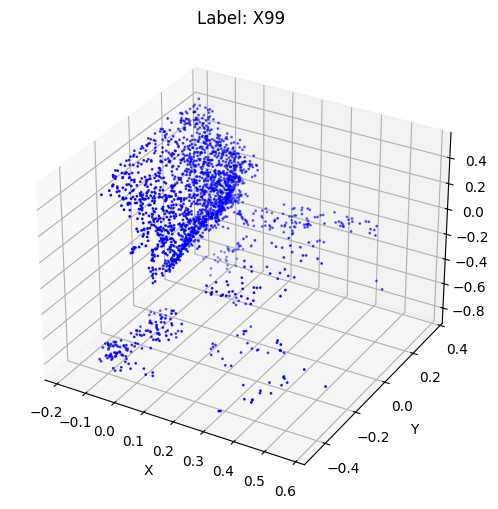

In [ ]:
#Visualization
index = 90
label_name = list(label_map.keys())[list(label_map.values()).index(labels[index])]
print(f"Label index: {labels[index]}, Label name: {label_name}")

visualize_sample(data[index], title=f"Label: {label_name}")

In [ ]:
print (data.shape)
print(label_map)

(1076, 2048, 3)
{'amia': 0, 'focusside': 1, 'torsa': 2, 'wittask': 3, 'X99': 4, 'X99 ': 5, 'X99.ply': 6}


In [ ]:
# Fix similar labels in label_map
correct_label_map = {'X99': 4}
corrections = {'X99 ': 'X99', 'X99.ply': 'X99'}

# Reverse label_map
reverse_label_map = {v: k for k, v in label_map.items()}

for i in range(len(labels)):
    label_name = reverse_label_map[labels[i]]
    if label_name in corrections:
        corrected_name = corrections[label_name]
        labels[i] = correct_label_map[corrected_name]

# build clean label_map
unique_label_names = ['amia', 'focusside', 'torsa', 'wittask', 'X99']
label_map = {name: idx for idx, name in enumerate(unique_label_names)}

print("Updated label_map:", label_map)

Updated label_map: {'amia': 0, 'focusside': 1, 'torsa': 2, 'wittask': 3, 'X99': 4}


In [ ]:
print(np.unique(labels))

[0 1 2 3 4]


In [ ]:
#Plot distribution of samples
def plot_label_distribution(labels, label_map):
    index_to_label = {v: k for k, v in label_map.items()}
    label_counts = Counter(labels)
    names = [index_to_label[i] for i in sorted(label_counts.keys())]
    counts = [label_counts[i] for i in sorted(label_counts.keys())]
    plt.figure(figsize=(10, 5))
    plt.bar(names, counts, color='skyblue')
    plt.xlabel('Chair Model (Label Name)')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Chair Models in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

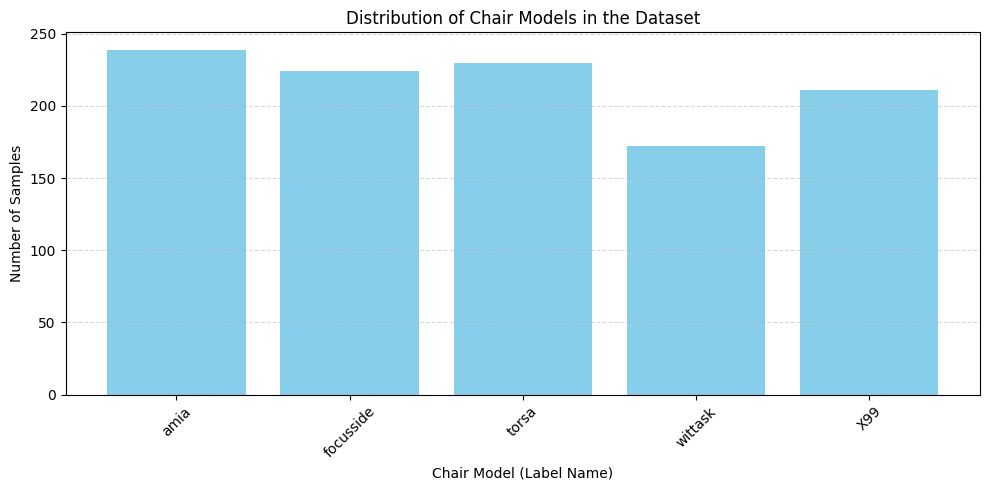

In [ ]:
plot_label_distribution(labels, label_map)

In [ ]:
#Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [ ]:
print(X_train.shape)

(860, 2048, 3)


In [ ]:
print(y_train.shape)

(860,)


In [ ]:
def build_pointnet_no_tnet(num_points=2048, input_channels=3, num_classes=5):
    inputs = tf.keras.Input(shape=(num_points, input_channels))
    xyz = inputs

    # Shared MLP (64, 64)
    feats = layers.Conv1D(64, 1, activation="relu")(xyz)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(64, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)

    # No feature T-Net here
    # Continue with MLP
    feats = layers.Conv1D(64, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(128, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(1024, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)

    x = layers.GlobalMaxPooling1D()(feats)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

In [ ]:
# Orthogonality loss
class OrthogonalRegularizer(layers.Layer):
    def __init__(self, lam=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.lam = lam

    def call(self, matrix):
        k = tf.shape(matrix)[-1]
        eye = tf.eye(k)
        mat_t = tf.transpose(matrix, perm=[0, 2, 1])
        diff = tf.matmul(matrix, mat_t) - eye
        loss = self.lam * tf.reduce_mean(tf.square(diff))
        self.add_loss(loss)
        return matrix

In [ ]:
# T-Net layers
def tnet(inputs, k):
    x = layers.Conv1D(64, 1, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, 1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    eye = np.eye(k).flatten()
    bias_init = tf.keras.initializers.Constant(eye)
    x = layers.Dense(k * k, kernel_initializer="zeros", bias_initializer=bias_init)(x)
    return layers.Reshape((k, k))(x)

# Transformation layer
class TransformLayer(layers.Layer):
    def __init__(self, k):
        super().__init__()
        self.k = k

    def call(self, inputs):
        feats, T = inputs
        return tf.matmul(feats, T)

In [ ]:
# Full PointNet model
def build_pointnet(num_points=2048, input_channels=3, num_classes=5, lam=1e-3):
    inputs = tf.keras.Input(shape=(num_points, input_channels))
    xyz = inputs  # Already only XYZ coordinates

    # Input T-Net
    T0 = tnet(xyz, k=3)
    T0 = OrthogonalRegularizer(lam)(T0)
    xyz = TransformLayer(3)([xyz, T0])

    # Shared MLP (64, 64)
    feats = layers.Conv1D(64, 1, activation="relu")(xyz)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(64, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)

    # Feature T-Net
    T1 = tnet(feats, k=64)
    T1 = OrthogonalRegularizer(lam)(T1)
    feats = TransformLayer(64)([feats, T1])

    # Shared MLP (64, 128, 1024)
    feats = layers.Conv1D(64, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(128, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(1024, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)

    # Global feature
    x = layers.GlobalMaxPooling1D()(feats)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

In [ ]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
num_classes = y_train.shape[1]

model = build_pointnet_no_tnet(num_points=2048,
                       input_channels=3,
                       num_classes=num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop, reduce_lr],
                    shuffle=True)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.4929 - loss: 1.6250 - val_accuracy: 0.2222 - val_loss: 1.6743 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accuracy: 0.6327 - loss: 1.0222 - val_accuracy: 0.2037 - val_loss: 1.6915 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 215s 6s/step - accuracy: 0.6485 - loss: 0.9678 - val_accuracy: 0.2639 - val_loss: 1.5261 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.6364 - loss: 0.9018 - val_accuracy: 0.3102 - val_loss: 1.5277 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.6135 - loss: 0.9731 - val_accuracy: 0.4306 - val_loss: 1.3284 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.6419 - loss: 0.8482 - val_accuracy: 0.4861 - val_loss: 1.2719 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.6838 - loss: 0.7987 - val_acc

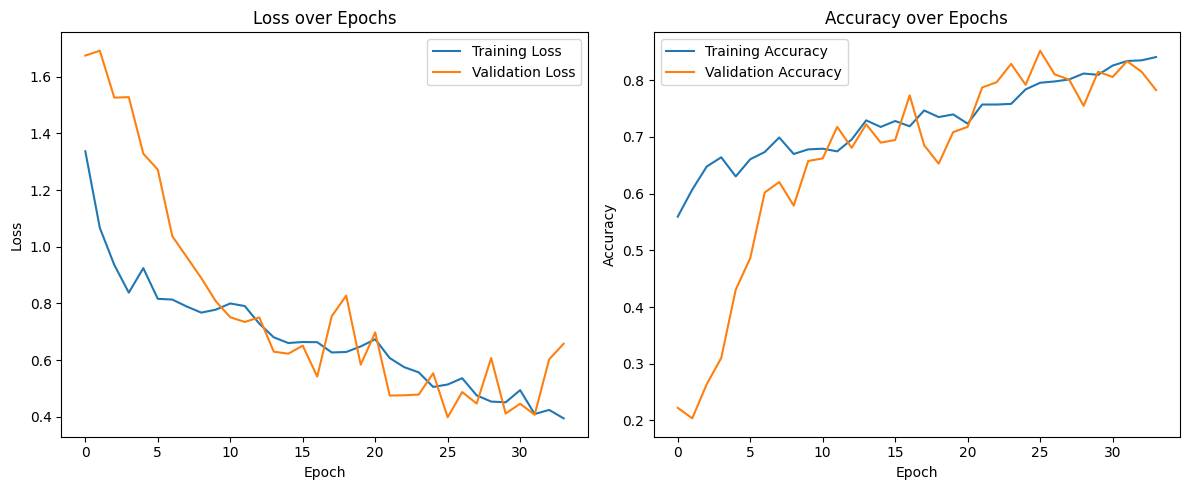

In [ ]:
# Plotting function
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_curves(history)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8687 - loss: 0.3936
Test Loss: 0.3984
Test Accuracy: 85.19%


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 918ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.76        48
           1       0.78      0.87      0.82        45
           2       0.86      0.91      0.88        46
           3       0.85      0.83      0.84        35
           4       0.95      0.95      0.95        42

    accuracy                           0.85       216
   macro avg       0.85      0.85      0.85       216
weighted avg       0.85      0.85      0.85       216



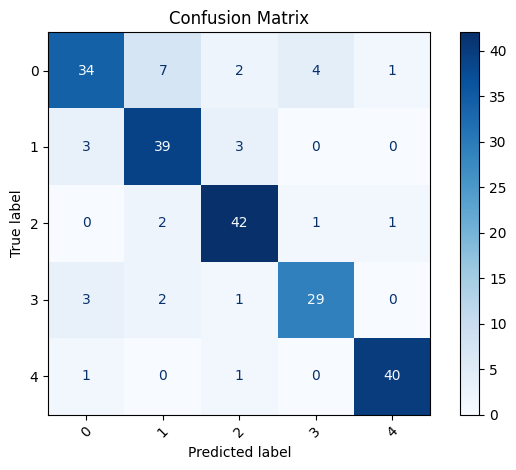

In [ ]:
# Convert one-hot to labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Per-class perfoamnce
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(class_accuracy):
    class_name = [k for k, v in label_map.items() if v == idx][0]
    print(f"{class_name:>10}: {acc * 100:.2f}%")

      amia: 70.83%
 focusside: 86.67%
     torsa: 91.30%
   wittask: 82.86%
       X99: 95.24%


True: wittask, Predicted: wittask


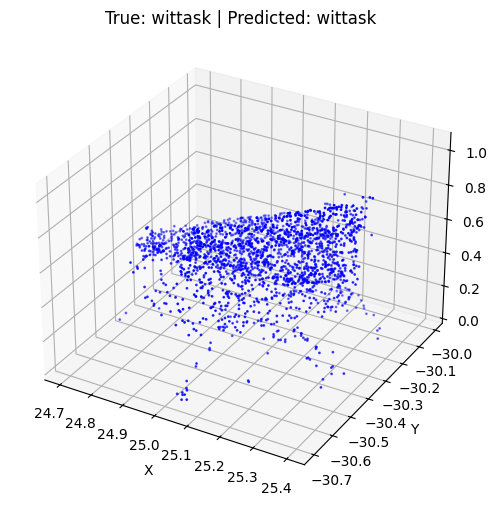

True: amia, Predicted: amia


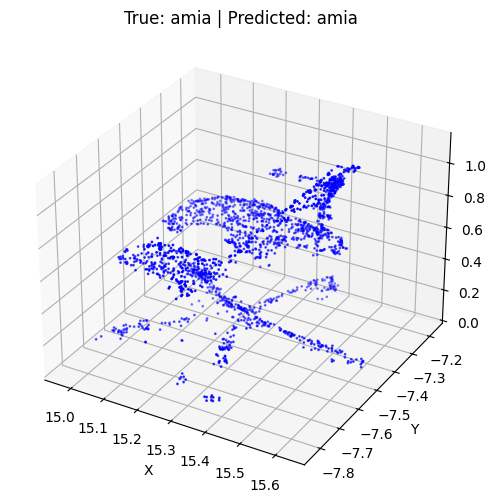

True: torsa, Predicted: torsa


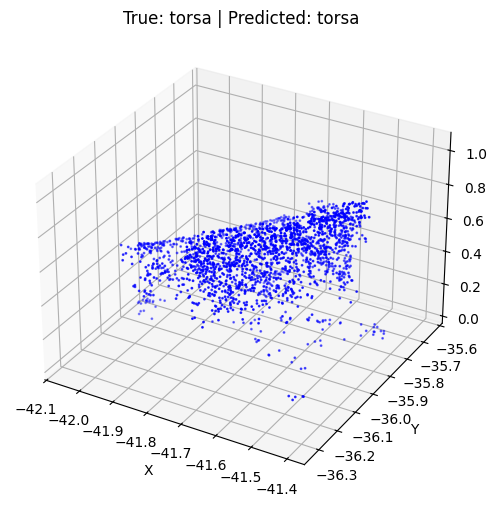

In [ ]:
#test the trained model
for _ in range(3):
    i = np.random.randint(0, len(X_test))
    pred_label = [k for k, v in label_map.items() if v == y_pred[i]][0]
    true_label = [k for k, v in label_map.items() if v == y_true[i]][0]

    print(f"True: {true_label}, Predicted: {pred_label}")
    visualize_sample(X_test[i], title=f"True: {true_label} | Predicted: {pred_label}")